In [1]:
import numpy as np
import pyarrow as pa
import h5py
from src.generators import *
import time
from matplotlib import pyplot as plt
np.random.seed(0)

In [2]:
N = [10,100,200,300,500]

In [3]:
generator = F1()
for item in N:
    generator.create_dataset(item,f"parquet_{item}")

In [3]:
generator = F1()
for item in N:
    generator.create_dataset(item,f"h5py_{item}.h5")

In [10]:
def is_leaf(name, node):
    """Check if a node is a dataset (leaf)."""
    return isinstance(node, h5py.Dataset)

def find_leaf_datasets(hdf5_file):
    """Find and return paths to all leaf datasets in an HDF5 file."""
    leaf_datasets = []

    # Traverse the HDF5 file
    hdf5_file.visititems(lambda name, node: leaf_datasets.append(name) if is_leaf(name, node) else None)
    
    return leaf_datasets

def string_with_most_char(strings, char):
    # Initialize variables to track the string with the most occurrences
    max_count = 0
    result_string = ""

    # Iterate through the list of strings
    for s in strings:
        # Count occurrences of the specified character in the current string
        count = s.count(char)
        
        # Update if the current string has more occurrences
        if count > max_count:
            max_count = count
            result_string = s

    return result_string

# HDF5

In [20]:
t = []

for item in N:
    start_time = time.time()
    with h5py.File(f'h5py_{item}.h5', 'r', driver="core") as f:
        print(string_with_most_char(find_leaf_datasets(f),"/"))
        data = f[find_leaf_datasets(f)[0]][:]
        end_time = time.time()
    t.append(end_time-start_time)

example_0/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image
example_0/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image
example_0/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image
example_0/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image
example_0/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image


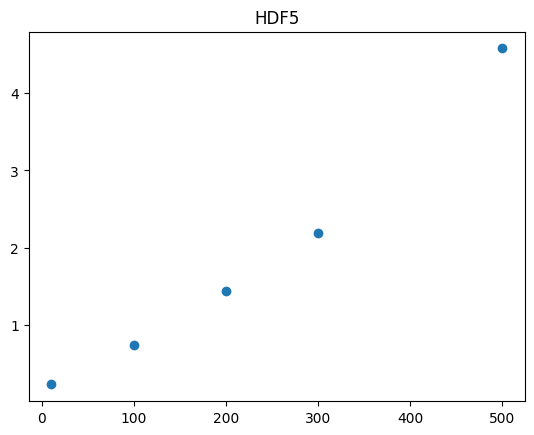

In [22]:
plt.title("HDF5")
plt.scatter(N,t)